In [1]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf

In [2]:
def read_and_convert(path_to_image_file):
    image2bytes = np.array(Image.open(path_to_image_file)).tobytes()
    label = [6,6,6,6]
    
    # the 'value' must be the type of [list] as follows.
    example = tf.train.Example(features=tf.train.Features(feature={
            'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image2bytes])),
            'label': tf.train.Feature(int64_list=tf.train.Int64List(value=label))
        }))
    return example
    

In [3]:
path_to_tfrecords_file = './data/images.tfrecords'
writer = tf.python_io.TFRecordWriter(path_to_tfrecords_file)

path_to_dataset_dir = './data/images'
path_to_image_files = tf.gfile.Glob(os.path.join(path_to_dataset_dir, '*.jpg'))
total_files = len(path_to_image_files)

print('%d files found in %s' % (total_files, path_to_dataset_dir))

for index, path_to_image_file in enumerate(path_to_image_files):
    print('(%d/%d) processing %s' % (index + 1, total_files, path_to_image_file))
    
    example = read_and_convert(path_to_image_file)
    if example is None:
        break
    writer.write(example.SerializeToString())
        
writer.close()
    

7 files found in ./data/images
(1/7) processing ./data/images/bridge.jpg
(2/7) processing ./data/images/airplane.jpg
(3/7) processing ./data/images/baboon.jpg
(4/7) processing ./data/images/lake.jpg
(5/7) processing ./data/images/couple.jpg
(6/7) processing ./data/images/Lena.jpg
(7/7) processing ./data/images/crowd.jpg


In [4]:
def read_and_decode(filename_queue):
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
        serialized_example,
        features={
            'image': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([4], tf.int64)
        })
    image = tf.decode_raw(features['image'], tf.uint8)
    image = tf.reshape(image, [512, 512, 1])
    label = tf.cast(features['label'], tf.int32)
    
    return image,label


In [5]:
assert tf.gfile.Exists(path_to_tfrecords_file), '%s not found' % path_to_tfrecords_file
filename_queue = tf.train.string_input_producer([path_to_tfrecords_file], num_epochs=None)

image, label = read_and_decode(filename_queue)

imgL = []
labelL = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) 
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess,coord=coord)
    
    # note the type of [list] in run()
    for _ in range(total_files):
        img,l = sess.run([image, label])
        imgL.append(img)
        labelL.append(l)
    
    coord.request_stop()
    coord.join(threads)


Populating the interactive namespace from numpy and matplotlib
[6 6 6 6]


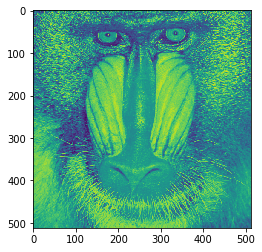

In [6]:
%pylab inline
image = imgL[2]
image = image.reshape(512,512)

print(labelL[0])
imshow(image)